Select the image to be processed:
1.Flevoland - area 1
2.San Francisco
type the option:1
Computing Flevoland area - region 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


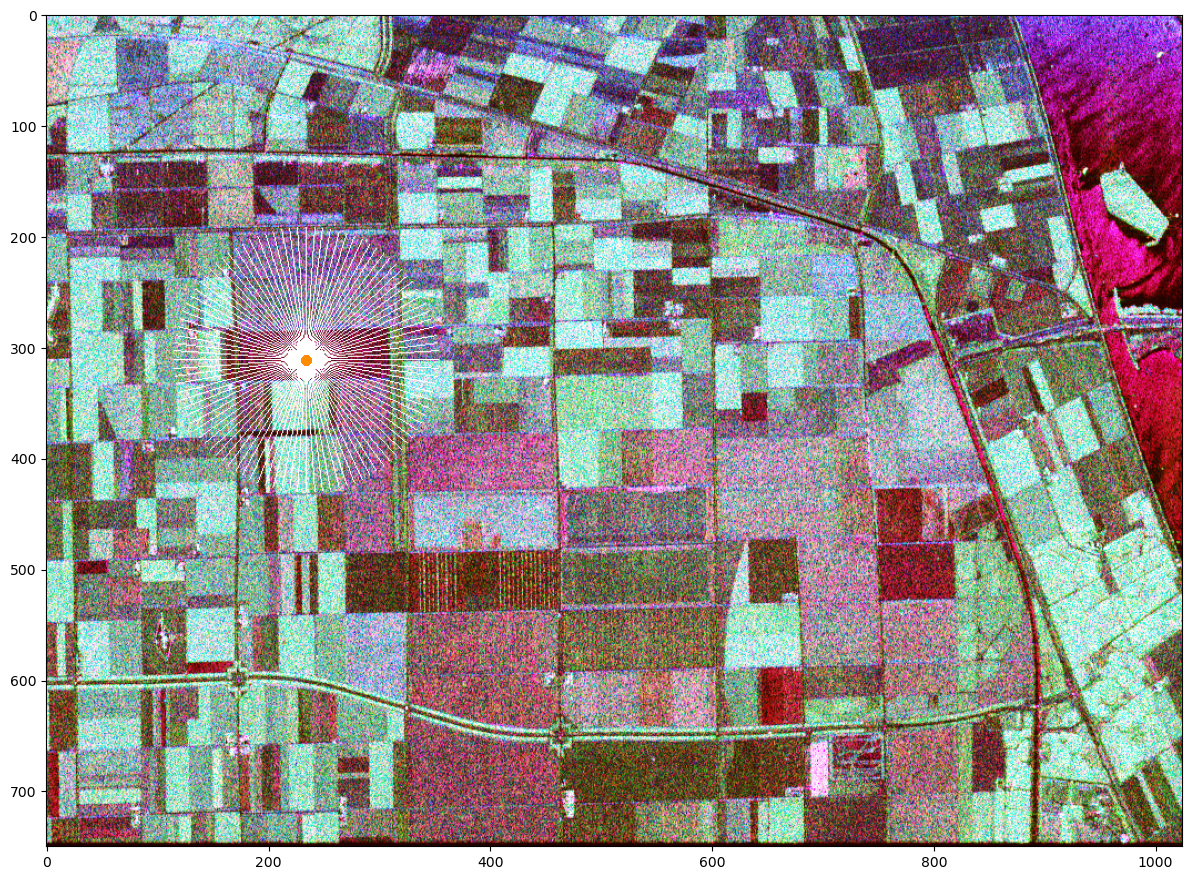

figure
figure
C:\Users\ander\OneDrive\Documentos\MEGA\MEGAsync\mack\alejandro\2023\art_rem_sens_01\artigo_fonte\figure\flev_ev_hh_roi_01.pdf
#########


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [1]:
### Version 03/08/2021
# Article GRSL
# Ref:
# A. A. De Borba,
# M. Marengoni and
# A. C. Frery,
# "Fusion of Evidences in Intensity Channels for Edge Detection in PolSAR Images,"
# in IEEE Geoscience and Remote Sensing Letters,
#doi: 10.1109/LGRS.2020.3022511.
# bibtex
#@ARTICLE{9203845,
#  author={De Borba, Anderson A. and Marengoni, Maurício and Frery, Alejandro C.},
#  journal={IEEE Geoscience and Remote Sensing Letters},
#  title={Fusion of Evidences in Intensity Channels for Edge Detection in PolSAR Images},
#  year={2020},
#  volume={},
#  number={},
#  pages={1-5},
#  doi={10.1109/LGRS.2020.3022511}}
#
## Import all required libraries
import numpy as np
## Used to read images in the mat format
import scipy.io as sio
## Used to equalize histograms in images
from skimage import exposure
## Used to present the images
import matplotlib as mpl
import matplotlib.pyplot as plt
## Used to find border evidences
import math
from scipy.optimize import dual_annealing
## Used in the DWT and SWT fusion methods
import pywt
#### Used to find_evidence_bfgs
from scipy.optimize import minimize
## Used
### Import mod
# see file  /Misc/mod_code_py.pdf
#
import polsar_basics as pb
import polsar_loglikelihood as plk
import polsar_fusion as pf
import polsar_total_loglikelihood as ptl
import polsar_evidence_lib as pel
import polsar_plot as pplt
#
## This function defines the source image and all the dat related to the region where we want
## to find borders
## Defines the ROI center and the ROI boundaries. The ROI is always a quadrilateral defined from the top left corner
## in a clockwise direction.
#
def select_data():
    print("Select the image to be processed:")
    print("1.Flevoland - area 1")
    print("2.San Francisco")
    opcao=int(input("type the option:"))
    if opcao==1:
        print("Computing Flevoland area - region 1")
        imagem="./Data/AirSAR_Flevoland_Enxuto.mat"
        ## values adjusted visually - it needs to be defined more preciselly
        ## delta values from the image center to the ROI center
        dx=278
        dy=64
        ## ROI coordinates
        x1 = 157;
        y1 = 284;
        x2 = 309;
        y2 = 281;
        x3 = 310;
        y3 = 327;
        x4 = 157;
        y4 = 330;
        ## inicial angle to start generating the radius
        alpha_i = 0.0
        ## final angle to start generating the radius
        alpha_f = 2 * np.pi
        ## slack constant
        lim = 14
    else:
        print("Computing San Francisco Bay area - region 1")
        imagem="./Data/SanFrancisco_Bay.mat"
        ## values adjusted visually - it needs to be defined more preciselly
        ## delta values from the image center to the ROI center
        dx=50
        dy=-195
        ## ROI coordinates
        x1 = 180;
        y1 = 362;
        x2 = 244;
        y2 = 354;
        x3 = 250;
        y3 = 420;
        x4 = 188;
        y4 = 427;
        ## inicial angle to start generating the radius
        alpha_i = np.pi
        ## final angle to start generating the radius
        alpha_f = 3 * np.pi / 2
        ## slack constant
        lim = 25
    ## Radius length
    RAIO=120
    ## Number of radius used to find evidence considering a whole circunference
    NUM_RAIOS=100
    ## adjust the number of radius based on the angle defined above
    if (alpha_f-alpha_i)!=(2*np.pi):
        NUM_RAIOS=int(NUM_RAIOS*(alpha_f-alpha_i)/(2*np.pi))
    gt_coords=[[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
    #
    return imagem, dx, dy, RAIO, NUM_RAIOS, alpha_i, alpha_f, lim, gt_coords
# ### A célula abaixo funciona como um main do código de fusão de evidências de borda em imagens POLSAR - ainda deverá ser editado para uma melhor compreensão do código ###
# The code works as main to GRSL2020 codes
#
cs1 = 'flev_ev_hh_roi_01'
cs2 = 'flev_ev_hv_roi_01'
cs3 = 'flev_ev_vv_roi_01'
## Define the image and the data from the ROI in the image
imagem, dx, dy, RAIO, NUM_RAIOS, alpha_i, alpha_f, lim, gt_coords = select_data()
#
## Reads the image and return the image, its shape and the number of channels
img, nrows, ncols, nc = pb.le_imagem(imagem)
#
## Plot parameter
img_rt = nrows/ncols
#
## Uses the Pauli decomposition to generate a visible image
PI = pb.show_Pauli(img, 1, 0)
#
## Define the radius in the ROI
x0, y0, xr, yr = pb.define_radiais(RAIO, NUM_RAIOS, dx, dy, nrows, ncols, alpha_i, alpha_f)
#
MXC, MYC, MY, IT, PI = pb.desenha_raios(ncols, nrows, nc, RAIO, NUM_RAIOS, img, PI, x0, y0, xr, yr)
#
## Define the number of channels to be used to find evidence
## and realize the fusion in the ROI
ncanal = 7
#total_canal = 7
evidencias = np.zeros((NUM_RAIOS, ncanal))
## Find the evidences
# Intensity channals pdf (gamma pdf)
#evidencias[:, 0] = pel.find_evidence_bfgs(RAIO, NUM_RAIOS, 0, MY, lim)
#evidencias[:, 1] = pel.find_evidence_bfgs(RAIO, NUM_RAIOS, 1, MY, lim)
#evidencias[:, 2] = pel.find_evidence_bfgs(RAIO, NUM_RAIOS, 2, MY, lim)
# Span pdf
#evidencias[:, 3] =  pel.find_evidence_bfgs_span(RAIO, NUM_RAIOS, MY, lim)
# Ratio intensities pdf ( inum / idem )
inum = 0
idem = 1
#evidencias[:, 4] = pel.find_evidence_bfgs_intensity_ratio(RAIO, NUM_RAIOS, MY, lim, inum, idem)
inum = 0
idem = 2
#evidencias[:, 5] = pel.find_evidence_bfgs_intensity_ratio(RAIO, NUM_RAIOS, MY, lim, inum, idem)
inum = 1
idem = 2
#evidencias[:, 6] = pel.find_evidence_bfgs_intensity_ratio(RAIO, NUM_RAIOS, MY, lim, inum, idem)

## Put the evidences in an image
#IM = pel.add_evidence(nrows, ncols, ncanal, evidencias, NUM_RAIOS, MXC, MYC)
## Computes fusion using mean - metodo = 1
#MEDIA = pf.fusao(IM, 1, NUM_RAIOS)

## Computes fusion using pca - metodo = 2
#PCA = pf.fusao(IM, 2, NUM_RAIOS)

## Computes fusion using ROC - metodo = 3
#ROC = pf.fusao(IM, 3, NUM_RAIOS)

## Testing fusion using SVD - metodo = 4
#SVD = pf.fusao(IM, 4, NUM_RAIOS)

## Testing fusion using SWT - metodo = 5
#SWT = pf.fusao(IM, 5, NUM_RAIOS)

## Testing fusion using DWT - metodo = 6
#DWT = pf.fusao(IM, 6, NUM_RAIOS)
#
# The edges evidence images are shown
#
PIE = pplt.show_evidence(PI, NUM_RAIOS, MXC, MYC, img_rt, evidencias, 0)
pplt.show_image_pauli_to_file(PIE, nrows, ncols, cs1)
#
PIE = pplt.show_evidence(PI, NUM_RAIOS, MXC, MYC, img_rt, evidencias, 1)
#pplt.show_image_pauli_to_file(PIE, nrows, ncols, cs2)
#
PIE = pplt.show_evidence(PI, NUM_RAIOS, MXC, MYC, img_rt, evidencias, 2)
#pplt.show_image_pauli_to_file(PIE, nrows, ncols, cs3)
#pel.show_evidence(PI, NUM_RAIOS, MXC, MYC, img_rt, evidencias, 3)
#pel.show_evidence(PI, NUM_RAIOS, MXC, MYC, img_rt, evidencias, 4)
#pel.show_evidence(PI, NUM_RAIOS, MXC, MYC, img_rt, evidencias, 5)
#pel.show_evidence(PI, NUM_RAIOS, MXC, MYC, img_rt, evidencias, 6)
#
# The images with fusion of evidence are shown
#
#pf.show_fusion_evidence(PI, nrows, ncols, MEDIA, img_rt)
#pf.show_fusion_evidence(PI, nrows, ncols, PCA, img_rt)
#pf.show_fusion_evidence(PI, nrows, ncols, ROC, img_rt)
#pf.show_fusion_evidence(PI, nrows, ncols, DWT, img_rt)
#pf.show_fusion_evidence(PI, nrows, ncols, SWT, img_rt)
#pf.show_fusion_evidence(PI, nrows, ncols, SVD, img_rt)
